<a href="https://colab.research.google.com/github/1213kush/1213kush/blob/main/GAN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
project_name = 'my_projects'

download the data from kaggle. so we have to put the api key of kaggle

firstly we have to create a api tokken form kaggle

In [2]:
{"username":"ankushpoddar","key":"1853eafc4fdeb2607af652cf75646296"}

{'username': 'ankushpoddar', 'key': '1853eafc4fdeb2607af652cf75646296'}

after that we can download the datasets form kaggle then no asy possiblities in error

In [3]:
!pip install opendatasets --upgrade --quiet

now import datasets from kaggle

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankushpoddar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:20<00:00, 20.6MB/s]


after downloading the dataset we can import the datasets from collab files

In [4]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [5]:
print(os.listdir(DATA_DIR+'/images')[:19])


['7929_2004.jpg', '46794_2014.jpg', '51913_2015.jpg', '63029_2019.jpg', '54548_2016.jpg', '57807_2017.jpg', '20681_2008.jpg', '33073_2011.jpg', '43372_2013.jpg', '4508_2003.jpg', '59849_2018.jpg', '6103_2003.jpg', '11111_2005.jpg', '29978_2010.jpg', '6370_2003.jpg', '8989_2004.jpg', '43049_2013.jpg', '17206_2007.jpg', '17332_2007.jpg']


lets loas this dataset using the ImageFolder class from torchvision. we can resize and crop this images to 64x64 px, and we can normalise the pixel values with mean of standard deviation of 0.5 for each channel , now we will ensure that the pixel value is (-1,1)


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [37]:
image_size = 64
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

now we apply transform 1.resize 2.centercrop 3.ToTensor = after croping we convert tensor after that this will be converts in pytorchtensor . finally we normalise that the values lies under in -1 to 1 ..4.Normalise

In [38]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

now we create helper function to denormalise the image tensor and display some sample images form a traning batch .

In [39]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

now we call show batch

In [41]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

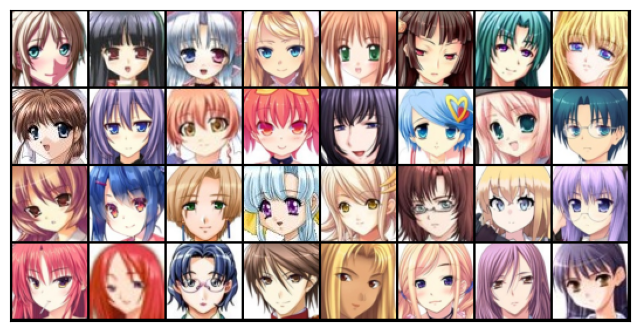

In [42]:
show_batch(train_dl)

befor the train the model then we want save own note book then save notebook

In [43]:
!pip install jovian --upgrade --quiet

In [44]:
import jovian

we import jovian due to if we leave a long time then g-collab is atomatically closed .so we need to connect by jovian

In [45]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


now we are using gpu . for both N/N 1- genrative 2- descriminate

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
#devicedataloader which moves the data in device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
#when we upload the data in for loop then we retrive the data . and tha data is batch so its move immeditely to gpu
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

now we select the device

In [47]:
device = get_default_device()
device

device(type='cuda')



---
we can now move our training data loader using DeviceDataLoader for automatically transferring batches of data to the gpu(is avail)


In [48]:
train_dl = DeviceDataLoader(train_dl, device)

now we have two types of n/n 1- generator and another is discriminator netwrk .

so we have Generater Network - its actually take random input . after that its will be train .. other hand we have descriminator network is - its classify the image which is real or fake if its fake then it agian epoch . its starting many times again and agian.

convolution neural network.. its take image and give a single number and this number is using to find the image is real or fake , both are depend upon based on probability..

In [49]:
import torch.nn as nn

now we are usnig convolution layer . after that we passing parameters hence we put the size of kernel_size = 4 , stride =2, padding =1 (after that if our image 4x4 then all side of image of infon can be obtain . other wise if the matricx of size is differ then some info can not be derive

now we appply layers of neural network

In [50]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

now we move the descriminator to device

In [51]:
discriminator = to_device(discriminator, device)

now we are using Generator Network : its take random input in the terms of matrics . and latent tensor is used to genrate the image. and latent tensor is used(128,1,1) and we take 128 random input in the form of channel . so we start processing and finally give any single input so , that we changing the value of genrator value and its give change in output , hence other terma is that if have latent tensor (128,1,1) to changing into imge size so we decrease the value of chanel and increase the value of pixel (3x28x28) its same as opposite of deconvolutional Netowork . also said that convTransposed2d.

In [52]:
latent_size = 128

for every convTranspose2d we are using a BatchNorms and ReLU = (ractified liner ) . stride 2 = is used for double the pixel size

In [53]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([32, 3, 64, 64])


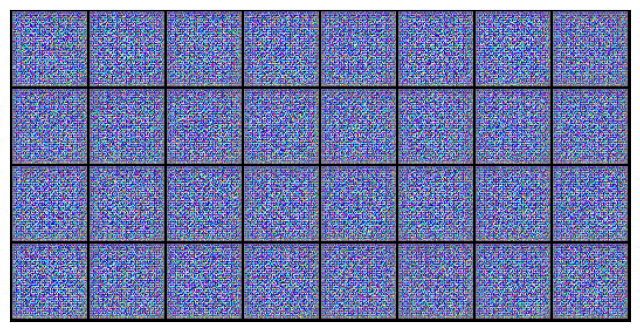

In [54]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

its gives a very noise image due to we only setup then its take random iamges , we updata and train our genrator the data continous and its causes the genrator and descriminitor become is trained

In [55]:
generator = to_device(generator, device)

now we move the genrator in our device .

now we will come on descriminator training .. discriminator only calasify thats the image is real or fake . its give a single number is used for probablity

here train_discriminator is a function . IN this function we are giving a real images . and real images is obtained from batchiamges .and passing through optimizers

In [56]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Generator training ....

In [57]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

before training we are look that there is no any validataion is set . so that we are doning one thing . for every epoch we drive a batch of images that can be saved in grid in the jpng form . in GAN we are analysis by visully due to we are not using any matrics of calcu(prob, accuraccy) we can see the discriminator is train then output is better or not

In [58]:
from torchvision.utils import save_image

now we are creating a file name genrated

In [59]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

here we are creating a save_sample class function .

In [60]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [61]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


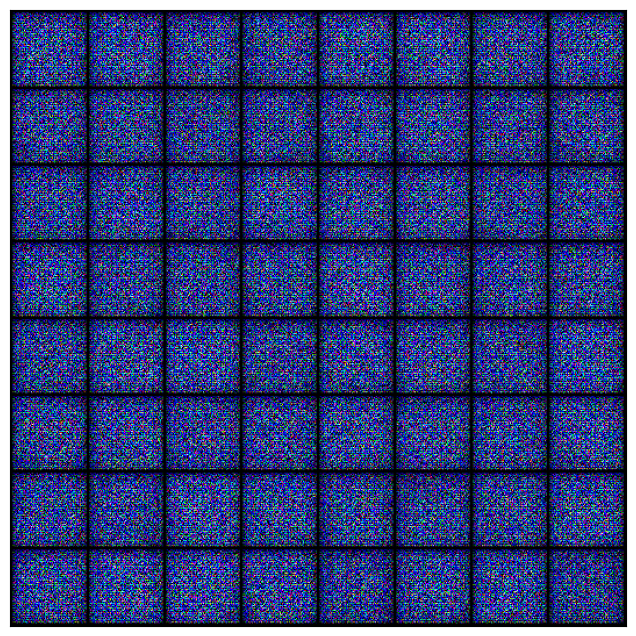

In [62]:
save_samples(0, fixed_latent)

In [63]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [66]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(25):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [67]:
lr = 0.0002
epochs = 25

In [68]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [69]:
history = fit(epochs, lr)

  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 9.0238, loss_d: 0.2364, real_score: 0.8014, fake_score: 0.0009
Saving generated-images-0001.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.8802, loss_d: 0.0151, real_score: 0.9905, fake_score: 0.0054
Saving generated-images-0002.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.9100, loss_d: 0.2060, real_score: 0.9093, fake_score: 0.0902
Saving generated-images-0003.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 12.8240, loss_d: 0.2174, real_score: 0.9991, fake_score: 0.1532
Saving generated-images-0004.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 10.0592, loss_d: 0.0161, real_score: 0.9851, fake_score: 0.0002
Saving generated-images-0005.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.8454, loss_d: 0.0830, real_score: 0.9612, fake_score: 0.0395
Saving generated-images-0006.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 16.9099, loss_d: 0.0819, real_score: 0.9959, fake_score: 0.0431
Saving generated-images-0007.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.8275, loss_d: 0.2850, real_score: 0.8667, fake_score: 0.0008
Saving generated-images-0008.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.4156, loss_d: 0.2127, real_score: 0.8711, fake_score: 0.0050
Saving generated-images-0009.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 11.8732, loss_d: 0.1259, real_score: 0.9978, fake_score: 0.0983
Saving generated-images-0010.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.2542, loss_d: 0.1847, real_score: 0.8975, fake_score: 0.0105
Saving generated-images-0011.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 1.9164, loss_d: 2.5166, real_score: 0.3145, fake_score: 0.0001
Saving generated-images-0012.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.0713, loss_d: 0.1385, real_score: 0.9023, fake_score: 0.0044
Saving generated-images-0013.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 9.2711, loss_d: 0.0594, real_score: 1.0000, fake_score: 0.0514
Saving generated-images-0014.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 1.3152, loss_d: 1.6449, real_score: 0.4262, fake_score: 0.0001
Saving generated-images-0015.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 8.1285, loss_d: 0.0076, real_score: 1.0000, fake_score: 0.0075
Saving generated-images-0016.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 7.2168, loss_d: 0.0768, real_score: 0.9306, fake_score: 0.0002
Saving generated-images-0017.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 17.2425, loss_d: 0.0056, real_score: 0.9982, fake_score: 0.0038
Saving generated-images-0018.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 7.4863, loss_d: 0.0646, real_score: 0.9519, fake_score: 0.0078
Saving generated-images-0019.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 8.3180, loss_d: 0.0858, real_score: 0.9445, fake_score: 0.0084
Saving generated-images-0020.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.2098, loss_d: 0.0455, real_score: 0.9914, fake_score: 0.0335
Saving generated-images-0021.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 11.3215, loss_d: 0.2900, real_score: 0.8067, fake_score: 0.0003
Saving generated-images-0022.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 1.0612, loss_d: 1.4935, real_score: 0.5107, fake_score: 0.0002
Saving generated-images-0023.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 10.1296, loss_d: 0.0055, real_score: 0.9947, fake_score: 0.0000
Saving generated-images-0024.png


  0%|          | 0/1987 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 9.9786, loss_d: 0.2492, real_score: 0.9069, fake_score: 0.1071
Saving generated-images-0025.png


In [70]:
losses_g, losses_d, real_scores, fake_scores = history

In [71]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [72]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [73]:
from IPython.display import Image

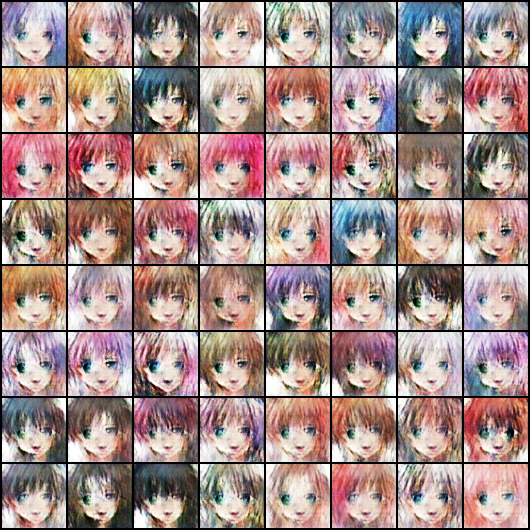

In [74]:
Image('./generated/generated-images-0001.png')

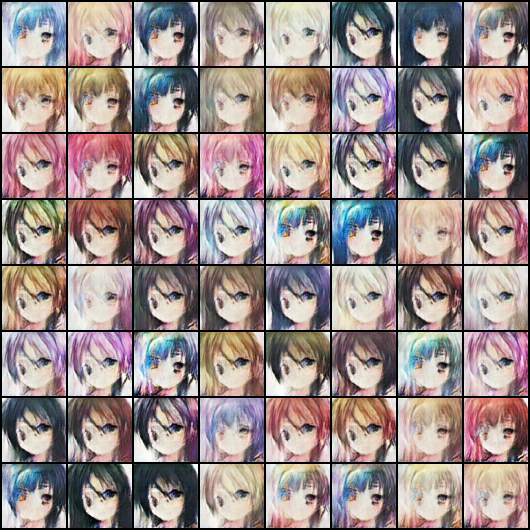

In [75]:
Image('./generated/generated-images-0005.png')

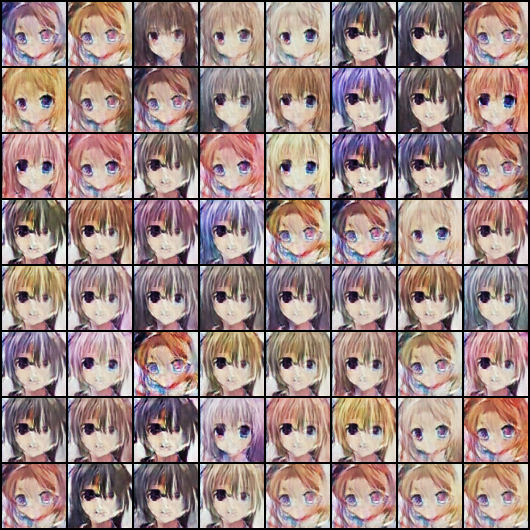

In [76]:
Image('./generated/generated-images-0010.png')

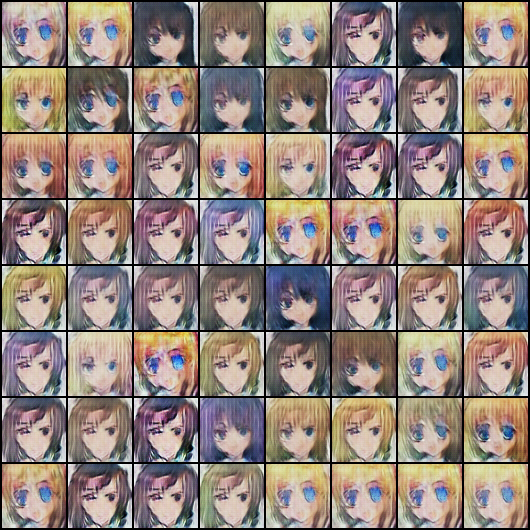

In [78]:
Image('./generated/generated-images-0020.png')

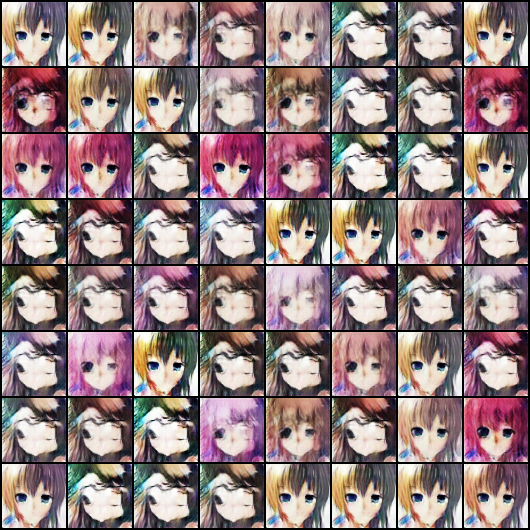

In [77]:
Image('./generated/generated-images-0025.png')

In [79]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

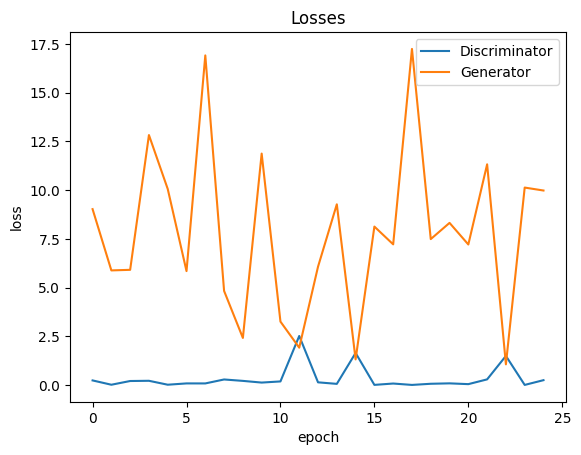

In [80]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

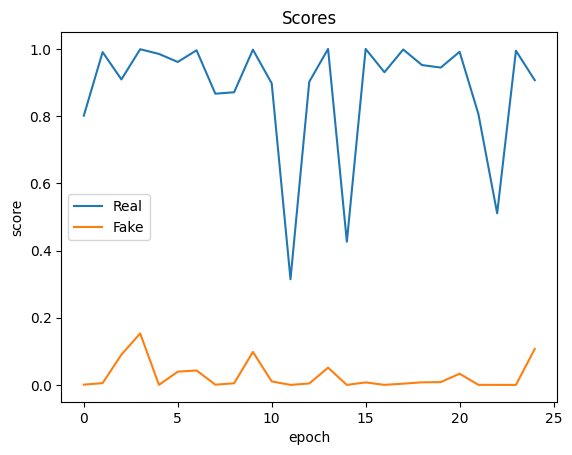

In [81]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [82]:
import jovian

In [83]:
jovian.commit(project=project_name,
              outputs=['G.pth', 'D.pth', 'gans_training.avi'],
              environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
